# Проект "Банковский Скоринг"


### В рамках этого проекта требовалось написать скоринговую модель предсказания дефолта клиентов банка.

У нас есть описание некоторых признаков из датасета:

* client_id	идентификатор клиента
* education	уровень образования
* sex	пол заёмщика
* age	возраст заёмщика
* car	флаг наличия автомобиля
* car_type	флаг автомобиля-иномарки
* decline_app_cnt	количество отказанных прошлых заявок
* good_work	флаг наличия «хорошей» работы
* bki_request_cnt	количество запросов в БКИ
* home_address	категоризатор домашнего адреса
* work_address	категоризатор рабочего адреса
* income	доход заёмщика
* foreign_passport	наличие загранпаспорта
* default	наличие дефолта

In [552]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns

from pandas import Series, DataFrame

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, recall_score, precision_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [553]:
# Зафиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [554]:
# Зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [555]:
# Загружаем данные в датасеты
DATA_DIR = '/kaggle/input/sf-dst-scoring/'
df_train = pd.read_csv(DATA_DIR+'/train.csv')
df_test = pd.read_csv(DATA_DIR+'test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [556]:
#Объединим train и test для обработки
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['default'] = 2 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем двойками

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

## Предобработка данных 

В датасете есть всего одна переменная с пропусками - это education. Заполним эти пропуски самыми часто встречающимися значениями этой переменной 


<AxesSubplot:>

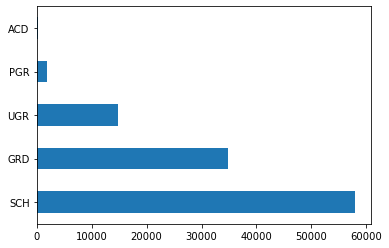

In [557]:
data['education'].value_counts().plot.barh()

In [558]:
data.loc[data.education.isna(), 'education'] = 'SCH'

In [559]:
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,2
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,2
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,2
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,0,2
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,0,2


In [560]:
# Поле education у нас имеет строковые значения, что не подходит для анализа и построения модели. Перекодируем его в числовые значения
education_dict = {
    'SCH': 1,
    'GRD': 2,
    'UGR': 3,
    'PGR': 4,
    'ACD': 5,
}

data['education'] = data['education'].map(education_dict)

## Анализ данных



Посмотрим на то, какие типы данных есть у нас в датасете

In [561]:
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,2,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,2
1,17527,24JAN2014,1,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,2
2,75683,23MAR2014,3,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,2
3,26883,03FEB2014,1,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,0,2
4,28862,04FEB2014,2,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,0,2


Выделим отдельно числовые, бинарные и категориальные переменные

In [562]:
numdata = data[['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki', 'region_rating']]

In [563]:
num_cols = numdata.columns.tolist()

In [564]:
bin_cols = data[['sex', 'car', 'car_type', 'foreign_passport', 'good_work']].columns.tolist()

In [565]:
cat_cols = data[['education', 'home_address', 'work_address', 'sna']].columns.tolist()

### Посмотрим на распределение числовых признаков

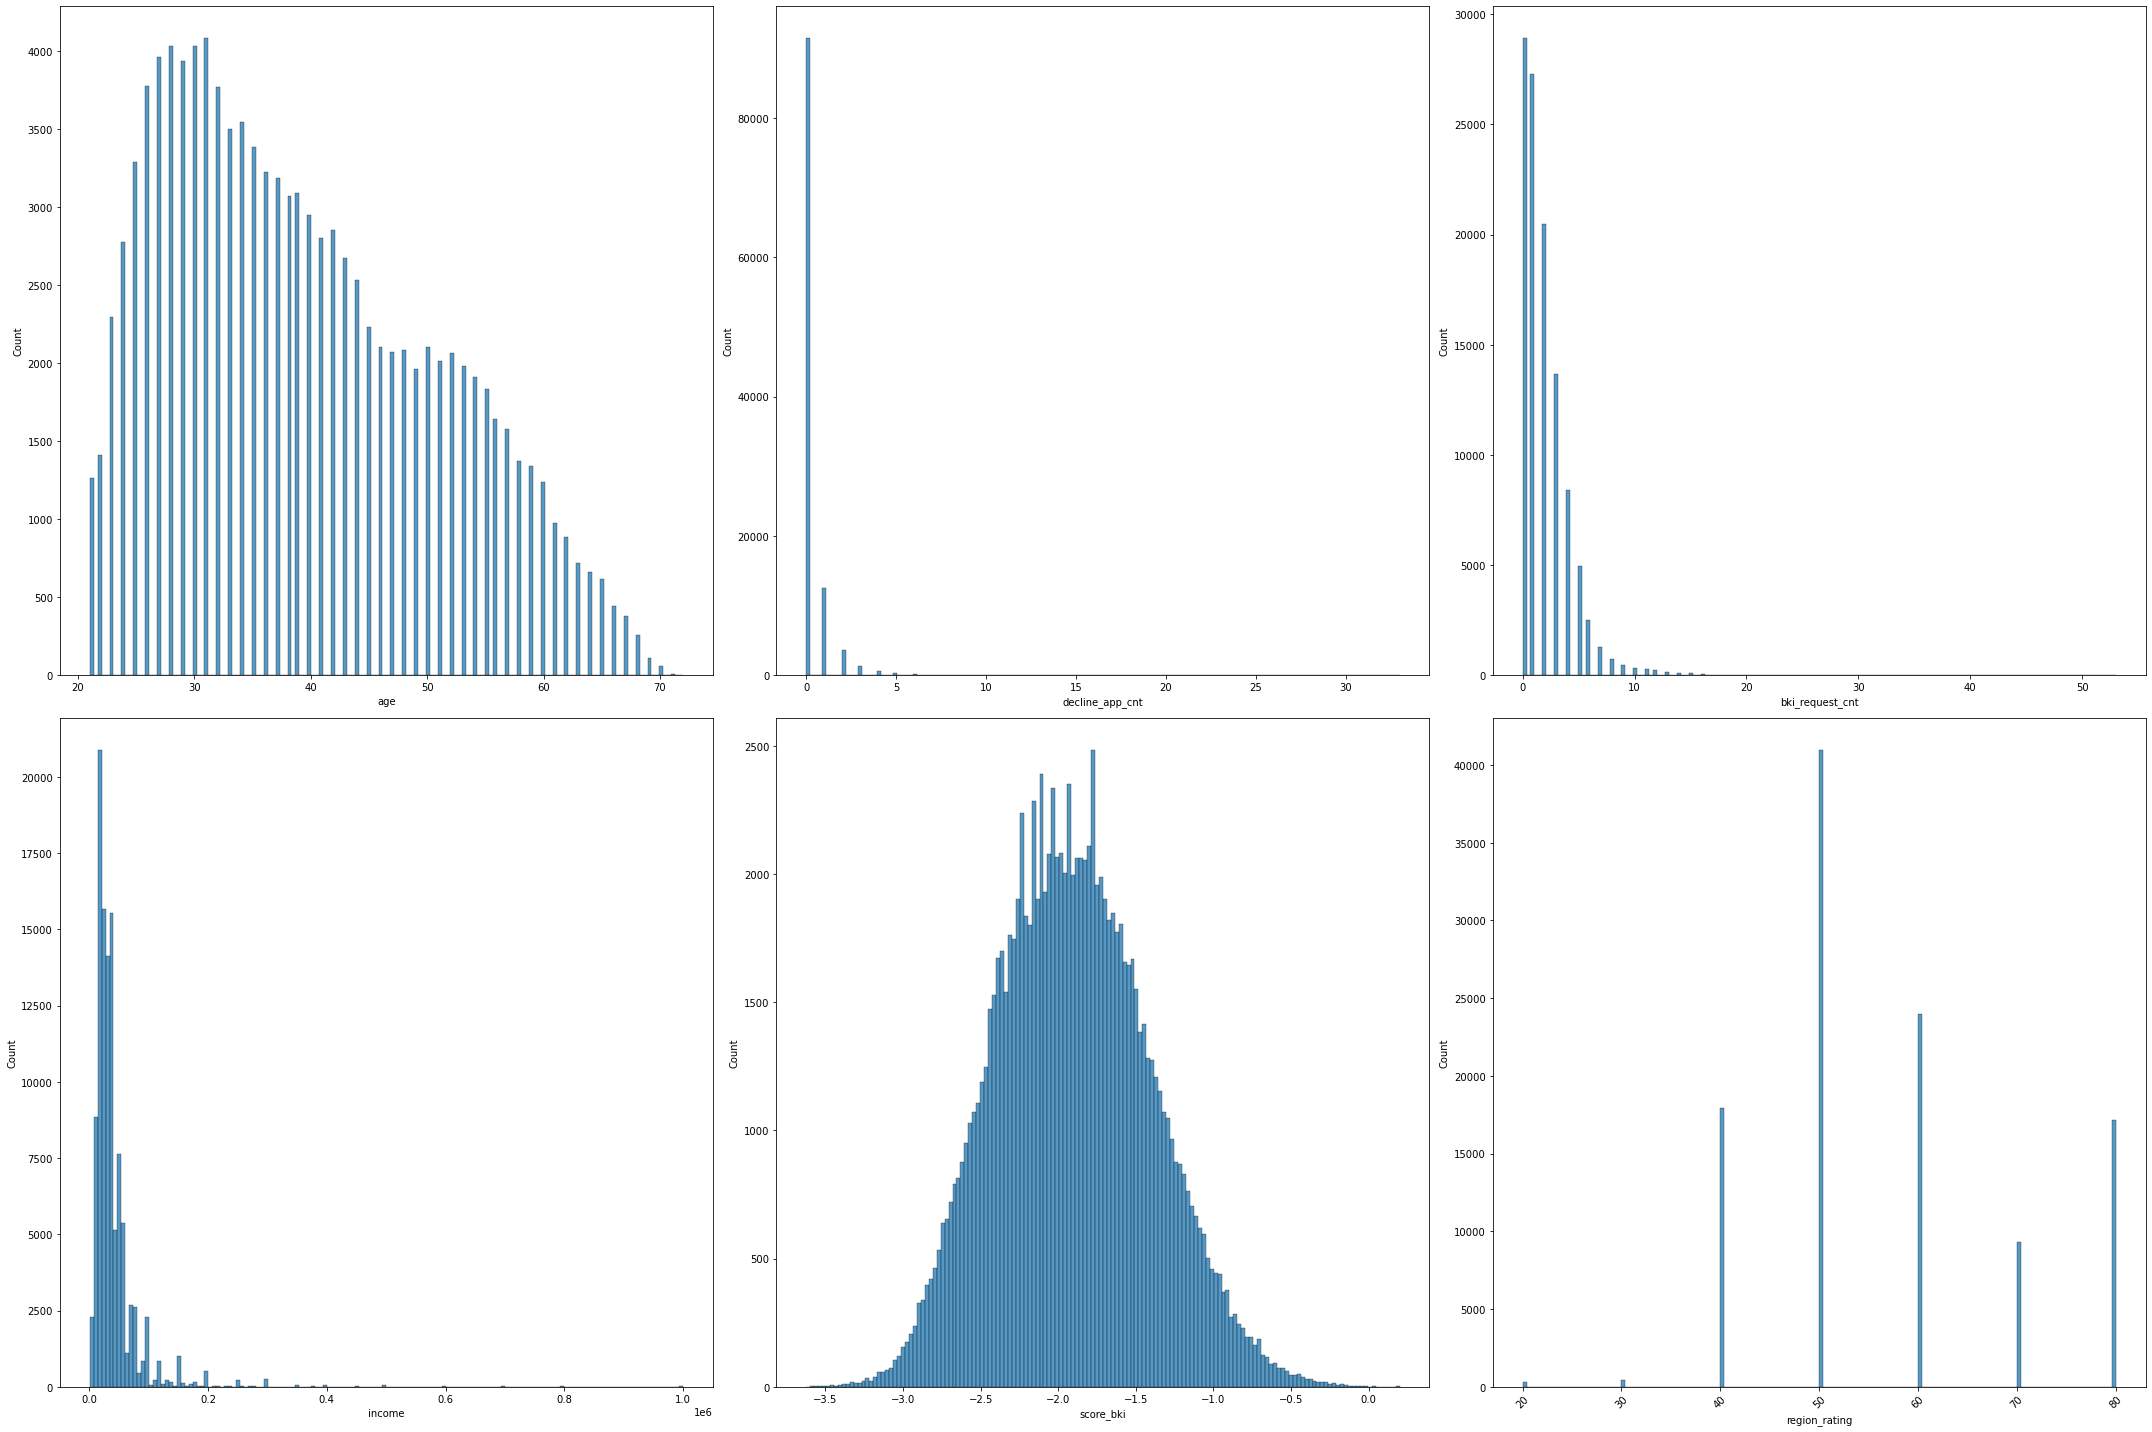

In [566]:
fig, axes = plt.subplots(2, 3, figsize=(30,20))
axes = axes.flatten() # переводим двумерный массив осей в одномерный для корректной индексации

i = 0
for col in num_cols:    
    ax = sns.histplot(x = col, 
                data=numdata.loc[numdata.loc[:, col].isin(numdata.loc[:, col].value_counts().index[:])],
               ax=axes[i], bins = 150)
    plt.xticks(rotation=45)        
    i+=1
    
fig.tight_layout() # развигаем диаграммы, чтобы не наезжали друг на друга

In [567]:
numdata.head()

,age,decline_app_cnt,bki_request_cnt,income,score_bki,region_rating
0,29,0,3,50000,-2.271884,50
1,39,5,2,5000,-1.504999,50
2,50,0,1,30000,-1.691339,50
3,56,0,1,17000,-2.374182,40
4,38,0,0,120000,-2.487502,80


Интересно, что переменная **score_bki** (очевидно внутренний score клиента в Бюро кредитных историй) имеет нормальное распределние. Остальные признаки имеют распределение далекое от нормального. Поэтому возможно их потребуется логарифмировать. Посмотрим, изменится ли распределение этих признаков, если их логарифмировать


In [568]:
numdata_log = numdata.copy()

In [569]:
for col in num_cols:
    numdata_log[col] = numdata[col].apply(lambda x: math.log(x) if x > 0 else x)

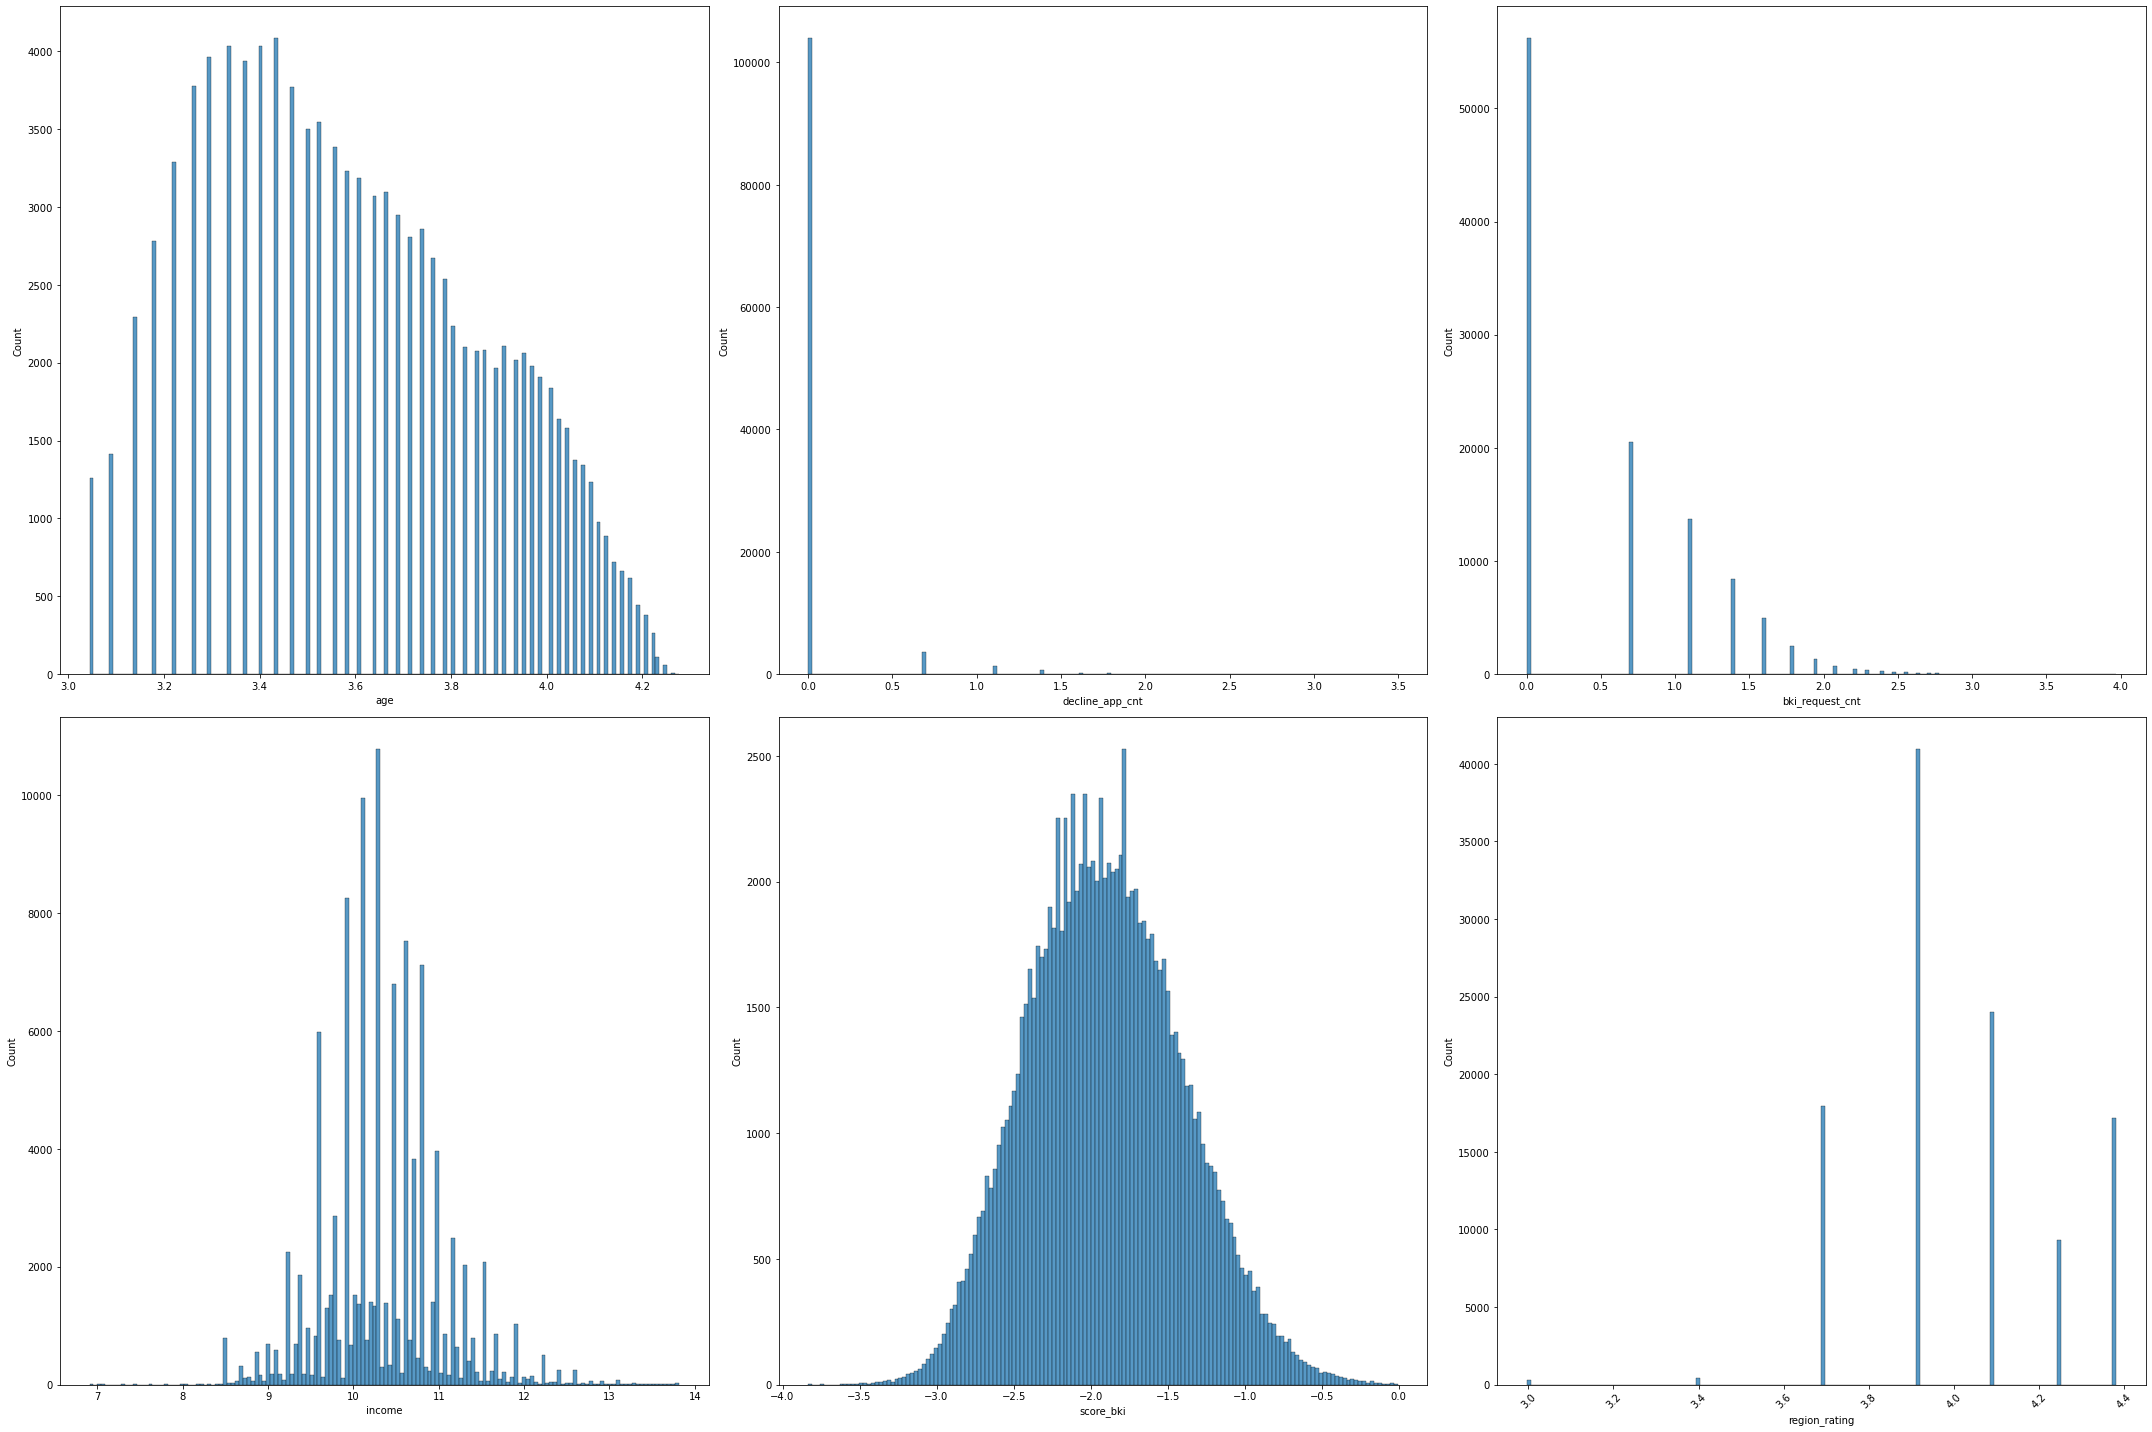

In [570]:
fig, axes = plt.subplots(2, 3, figsize=(30,20))
axes = axes.flatten() # переводим двумерный массив осей в одномерный для корректной индексации

i = 0
for col in num_cols:    
    ax = sns.histplot(x = col, 
                data=numdata_log.loc[numdata_log.loc[:, col].isin(numdata_log.loc[:, col].value_counts().index[:])],
               ax=axes[i], bins = 150)
    plt.xticks(rotation=45)        
    i+=1
    
fig.tight_layout() # развигаем диаграммы, чтобы не наезжали друг на друга

Видим, что распределение переменных income и age однозначно улучшилось после логарифмирования. Поэтому логарифмируем их для дальнейшего использования

In [571]:
data['age'] = np.log(data['age'] + 1)

In [572]:
data['income'] = np.log(data['income'] + 1)

Теперь посмотрим на корреляции между числовыми признаками

<AxesSubplot:>

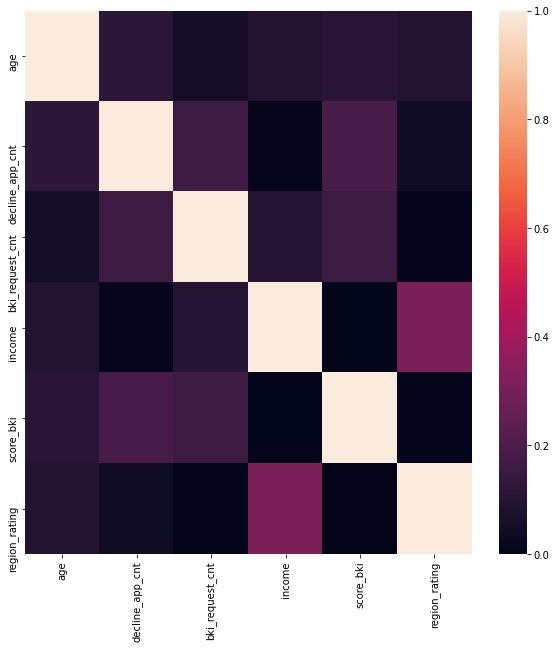

In [573]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1)

In [574]:
data[num_cols].corr().abs()

,age,decline_app_cnt,bki_request_cnt,income,score_bki,region_rating
age,1.000000,0.118243,0.052437,0.090734,0.109169,0.090629
decline_app_cnt,0.118243,1.000000,0.159927,0.010118,0.187869,0.038254
bki_request_cnt,0.052437,0.159927,1.000000,0.101127,0.157451,0.006780
income,0.090734,0.010118,0.101127,1.000000,0.002592,0.313187
score_bki,0.109169,0.187869,0.157451,0.002592,1.000000,0.007132
region_rating,0.090629,0.038254,0.006780,0.313187,0.007132,1.000000


Из графика и таблицы видно, что между числовыми признаками датасета нет сильных зависимостей, поэтому все признаки можно использовать для анализа данных

Взглянем теперь на корреляцию между числовыми признаками и целевой переменной. Для этого будем использовать датасет df_train, т.к. в нем есть целевые переменные

In [575]:
df_train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,1
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0,1
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0,1
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0,1


In [576]:
df_train[num_cols].corrwith(df_train['default'])

age               -0.025004
decline_app_cnt    0.113682
bki_request_cnt    0.078242
income            -0.039752
score_bki          0.175369
region_rating     -0.089035
dtype: float64

Из таблицы корреляции видно, что наибольшая корреляция существует между целевой переменной и количеством отказанных прошлых заявок(decline_app_cnt), а также между целевой переменной и рейтингом Бюро Кредитной Истории (score_bki) 

Посмотрим еще на значимость числовых переменных с помощью f-статистики

<AxesSubplot:>

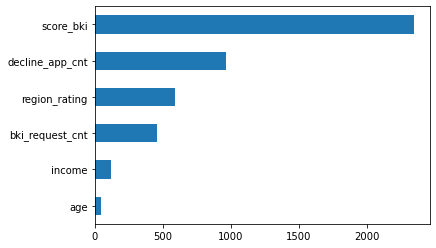

In [577]:
imp_num = Series(f_classif(df_train[num_cols], df_train['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Как видим, оценка f-score подтвердила важность двух переменных score_bki и decline_app_cnt для построения модели. Наименее важными при этом являются возраст(age) и доход (income). В то что доход никоим образом не влияет на прогноз верится мало, поэтому доход оставим для модели, а возраст уберем.

In [578]:
num_cols_imp = data[['decline_app_cnt', 'score_bki', 'bki_request_cnt', 'region_rating', 'income']].columns.tolist()

In [579]:
num_cols_imp

['decline_app_cnt', 'score_bki', 'bki_request_cnt', 'region_rating', 'income']

### Теперь поработаем с бинарными и категориальными признаками

In [580]:
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
    
# убедимся в преобразовании    
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,2,1,3.401197,1,1,0,0,-2.271884,3,50,1,2,10.819798,1,4,0,0,2
1,17527,24JAN2014,1,0,3.688879,0,0,5,0,-1.504999,2,50,1,2,8.517393,4,3,0,0,2
2,75683,23MAR2014,3,1,3.931826,1,1,0,0,-1.691339,1,50,1,2,10.308986,1,3,1,0,2
3,26883,03FEB2014,1,1,4.043051,0,0,0,0,-2.374182,1,40,1,2,9.741027,1,3,0,0,2
4,28862,04FEB2014,2,0,3.663562,0,0,0,0,-2.487502,0,80,2,3,11.695255,1,3,0,0,2


#### Для оценки значимости категориальных и бинарных переменных будем использовать функцию mutual_info_classif из библиотеки sklearn. Опять используем df_train поскольку в нем есть целевая переменная. Только проведем на df_train некоторые манипуляции, которые мы проводили над основнм датасетом

In [581]:
# Заполняем пустые значения признака education
df_train.loc[df_train.education.isna(), 'education'] = 'SCH'

In [582]:
# И перекодируем education в df_train в числовые значения
df_train['education'] = df_train['education'].map(education_dict)

In [583]:
#Также применем LabelEncoding для бинарных признаков для df_train
# Для бинарных признаков мы будем использовать LabelEncoder

for column in bin_cols:
    df_train[column] = label_encoder.fit_transform(df_train[column])
    
# убедимся в преобразовании    
df_train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
0,25905,01FEB2014,1,1,62,1,1,0,0,-2.008753,1,50,1,2,18000,4,1,0,0,1
1,63161,12MAR2014,1,0,59,0,0,0,0,-1.532276,3,50,2,3,19000,4,1,0,0,1
2,25887,01FEB2014,1,1,25,1,0,2,0,-1.408142,1,80,1,2,30000,1,4,1,0,1
3,16222,23JAN2014,1,0,53,0,0,0,0,-2.057471,2,50,2,3,10000,1,3,0,0,1
4,101655,18APR2014,2,1,48,0,0,0,1,-1.244723,1,60,2,3,30000,1,4,1,0,1


In [584]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73799 non-null  int64  
 3   sex               73799 non-null  int64  
 4   age               73799 non-null  int64  
 5   car               73799 non-null  int64  
 6   car_type          73799 non-null  int64  
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

<AxesSubplot:>

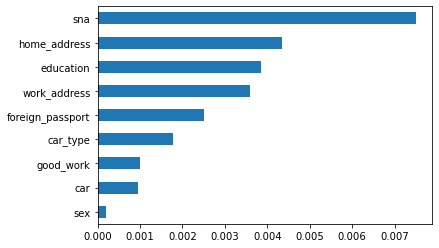

In [585]:
imp_cat = Series(mutual_info_classif(df_train[bin_cols + cat_cols], df_train['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Как видно из диаграммы из бинарных и категориальных признаков самыми важными являются sna, home_address, education, work_address. Это все - категориальные переменные, оставим их для обучения модели. Также оставим все бинарные признаки, т.к. они показали хорошую эффективность на предыдущих итерациях построения модели

In [586]:
cat_cols_imp = data[['education', 'home_address', 'work_address', 'sna']].columns.tolist()

In [587]:
cat_cols_imp

['education', 'home_address', 'work_address', 'sna']

In [588]:
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,2,1,3.401197,1,1,0,0,-2.271884,3,50,1,2,10.819798,1,4,0,0,2
1,17527,24JAN2014,1,0,3.688879,0,0,5,0,-1.504999,2,50,1,2,8.517393,4,3,0,0,2
2,75683,23MAR2014,3,1,3.931826,1,1,0,0,-1.691339,1,50,1,2,10.308986,1,3,1,0,2
3,26883,03FEB2014,1,1,4.043051,0,0,0,0,-2.374182,1,40,1,2,9.741027,1,3,0,0,2
4,28862,04FEB2014,2,0,3.663562,0,0,0,0,-2.487502,0,80,2,3,11.695255,1,3,0,0,2


In [589]:
# Закодимруем категориальные признаки, которые мы будем использовать в модели с помощью One Hot Encoding метода.
data = pd.get_dummies(data, prefix=cat_cols_imp, columns=cat_cols_imp)

#data_imp = pd.get_dummies(data_imp, prefix=cat_cols_imp, columns=cat_cols_imp)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 31 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   sex               110148 non-null  int64  
 3   age               110148 non-null  float64
 4   car               110148 non-null  int64  
 5   car_type          110148 non-null  int64  
 6   decline_app_cnt   110148 non-null  int64  
 7   good_work         110148 non-null  int64  
 8   score_bki         110148 non-null  float64
 9   bki_request_cnt   110148 non-null  int64  
 10  region_rating     110148 non-null  int64  
 11  income            110148 non-null  float64
 12  first_time        110148 non-null  int64  
 13  foreign_passport  110148 non-null  int64  
 14  sample            110148 non-null  int64  
 15  default           110148 non-null  int64  
 16  education_1       11

In [590]:
data.head()

,client_id,app_date,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,home_address_1,home_address_2,home_address_3,work_address_1,work_address_2,work_address_3,sna_1,sna_2,sna_3,sna_4
0,74835,22MAR2014,1,3.401197,1,1,0,0,-2.271884,3,...,1,0,0,0,1,0,1,0,0,0
1,17527,24JAN2014,0,3.688879,0,0,5,0,-1.504999,2,...,1,0,0,0,1,0,0,0,0,1
2,75683,23MAR2014,1,3.931826,1,1,0,0,-1.691339,1,...,1,0,0,0,1,0,1,0,0,0
3,26883,03FEB2014,1,4.043051,0,0,0,0,-2.374182,1,...,1,0,0,0,1,0,1,0,0,0
4,28862,04FEB2014,0,3.663562,0,0,0,0,-2.487502,0,...,0,1,0,0,0,1,1,0,0,0


### Подготовим датасет для обучения модели. Разобъем на тренинговую и тестову части

In [591]:
data.head()

,client_id,app_date,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,home_address_1,home_address_2,home_address_3,work_address_1,work_address_2,work_address_3,sna_1,sna_2,sna_3,sna_4
0,74835,22MAR2014,1,3.401197,1,1,0,0,-2.271884,3,...,1,0,0,0,1,0,1,0,0,0
1,17527,24JAN2014,0,3.688879,0,0,5,0,-1.504999,2,...,1,0,0,0,1,0,0,0,0,1
2,75683,23MAR2014,1,3.931826,1,1,0,0,-1.691339,1,...,1,0,0,0,1,0,1,0,0,0
3,26883,03FEB2014,1,4.043051,0,0,0,0,-2.374182,1,...,1,0,0,0,1,0,1,0,0,0
4,28862,04FEB2014,0,3.663562,0,0,0,0,-2.487502,0,...,0,1,0,0,0,1,1,0,0,0


In [592]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 31 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   sex               110148 non-null  int64  
 3   age               110148 non-null  float64
 4   car               110148 non-null  int64  
 5   car_type          110148 non-null  int64  
 6   decline_app_cnt   110148 non-null  int64  
 7   good_work         110148 non-null  int64  
 8   score_bki         110148 non-null  float64
 9   bki_request_cnt   110148 non-null  int64  
 10  region_rating     110148 non-null  int64  
 11  income            110148 non-null  float64
 12  first_time        110148 non-null  int64  
 13  foreign_passport  110148 non-null  int64  
 14  sample            110148 non-null  int64  
 15  default           110148 non-null  int64  
 16  education_1       11

In [593]:
# Удалим из датасета все ненужные признаки, которые мы не будем использовать для построения модели
data = data.drop(columns=['client_id', 'app_date', 'age'], axis = 1)

In [594]:
data.head()

,sex,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,income,first_time,...,home_address_1,home_address_2,home_address_3,work_address_1,work_address_2,work_address_3,sna_1,sna_2,sna_3,sna_4
0,1,1,1,0,0,-2.271884,3,50,10.819798,4,...,1,0,0,0,1,0,1,0,0,0
1,0,0,0,5,0,-1.504999,2,50,8.517393,3,...,1,0,0,0,1,0,0,0,0,1
2,1,1,1,0,0,-1.691339,1,50,10.308986,3,...,1,0,0,0,1,0,1,0,0,0
3,1,0,0,0,0,-2.374182,1,40,9.741027,3,...,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,0,-2.487502,0,80,11.695255,3,...,0,1,0,0,0,1,1,0,0,0


In [595]:
#Стандартизируем числовые признаки
data[num_cols_imp] = StandardScaler().fit_transform(data[num_cols_imp].values)

In [596]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 28 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   sex               110148 non-null  int64  
 1   car               110148 non-null  int64  
 2   car_type          110148 non-null  int64  
 3   decline_app_cnt   110148 non-null  float64
 4   good_work         110148 non-null  int64  
 5   score_bki         110148 non-null  float64
 6   bki_request_cnt   110148 non-null  float64
 7   region_rating     110148 non-null  float64
 8   income            110148 non-null  float64
 9   first_time        110148 non-null  int64  
 10  foreign_passport  110148 non-null  int64  
 11  sample            110148 non-null  int64  
 12  default           110148 non-null  int64  
 13  education_1       110148 non-null  uint8  
 14  education_2       110148 non-null  uint8  
 15  education_3       110148 non-null  uint8  
 16  education_4       11

In [597]:
# Разделяем датасет обратно на тренинговую и тестовую части 
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample', 'default'], axis=1)

In [598]:
#Выделяем целевую переменную и тренинговые данные для обучения модели
y = train_data['default']
train_data = train_data.drop(['default'], axis=1)
X = train_data

In [599]:
train_data.head()

,sex,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,income,first_time,...,home_address_1,home_address_2,home_address_3,work_address_1,work_address_2,work_address_3,sna_1,sna_2,sna_3,sna_4
36349,1,1,1,-0.341893,0,-0.208688,-0.443335,-0.516704,-0.786080,1,...,1,0,0,0,1,0,0,0,0,1
36350,0,0,0,-0.341893,0,0.745419,0.438921,-0.516704,-0.708472,1,...,0,1,0,0,0,1,0,0,0,1
36351,1,1,0,2.160936,0,0.993988,-0.443335,1.779355,-0.052834,4,...,1,0,0,0,1,0,1,0,0,0
36352,0,0,0,-0.341893,0,-0.306243,-0.002207,-0.516704,-1.629771,3,...,0,1,0,0,0,1,1,0,0,0
36353,1,0,0,-0.341893,1,1.321223,-0.443335,0.248649,-0.052834,4,...,0,1,0,0,0,1,1,0,0,0


**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. Это поможет нам проверить, как хорошо наша модель работает до отправки submissiona на Kaggle.**

In [601]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 30% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

### Проведем регуляризацию

In [602]:
# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=10, n_jobs=-1)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 1.0


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [603]:
# Обучим модель логистической регресии вначале без гиперпараметров
model1 = LogisticRegression()

In [604]:
model1.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [605]:
y_pred1 = model1.predict(X_test)

In [606]:
y_pred_proba1 = model1.predict_proba(X_test)[:,1]

In [607]:
print(f1_score(y_test, y_pred1))
print(precision_score(y_test, y_pred1))
print(recall_score(y_test, y_pred1))

0.04085801838610827
0.3821656050955414
0.02158273381294964


In [608]:
# Отрисовать ROC кривую
def calc_and_plot_roc(y_true, y_pred_proba):
    # Посчитать значения ROC кривой и значение площади под кривой AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.title('Receiver Operating Characteristic', fontsize=15)
    plt.xlabel('False positive rate (FPR)', fontsize=15)
    plt.ylabel('True positive rate (TPR)', fontsize=15)
    plt.legend(fontsize=15)

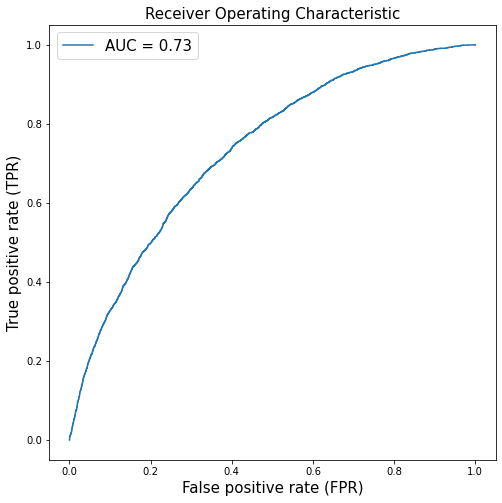

In [609]:
calc_and_plot_roc(y_test, y_pred_proba1)

Как видим, нам удалось улучшить базовый результат из курса за счет добавления новых данных. Попробуем добавить в модель разные гиперпараметры

In [610]:
model2 = LogisticRegression(C=1, penalty='l2')

In [611]:
model2.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1)

In [612]:
y_pred2 = model2.predict(X_test)

In [613]:
y_pred_proba2 = model2.predict_proba(X_test)[:,1]

In [614]:
print(f1_score(y_test, y_pred2))
print(precision_score(y_test, y_pred2))
print(recall_score(y_test, y_pred2))

0.04085801838610827
0.3821656050955414
0.02158273381294964


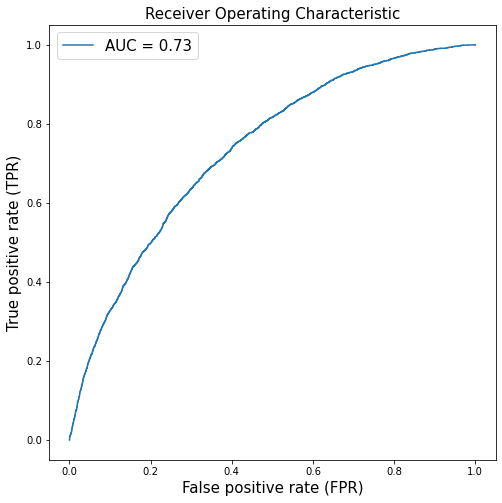

In [615]:
calc_and_plot_roc(y_test, y_pred_proba2)

In [616]:
model3 = LogisticRegression(C=100000, penalty='l2')

In [617]:
model3.fit(X_train, y_train)

LogisticRegression(C=100000)

In [618]:
y_pred3 = model3.predict(X_test)

In [619]:
y_pred_proba3 = model3.predict_proba(X_test)[:,1]

In [620]:
print(f1_score(y_test, y_pred3))
print(precision_score(y_test, y_pred3))
print(recall_score(y_test, y_pred3))

0.04020442930153322
0.38064516129032255
0.021223021582733814


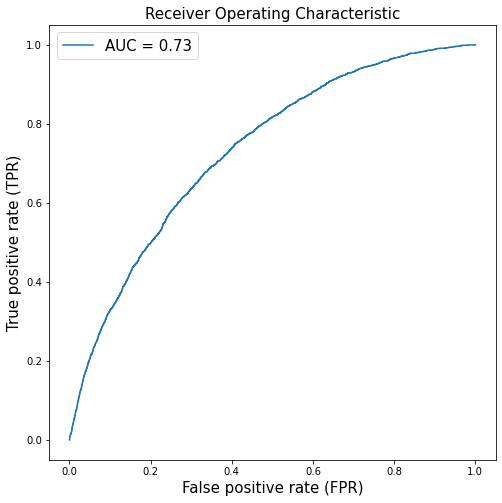

In [621]:
calc_and_plot_roc(y_test, y_pred_proba3)

Как видим гиперпараметры не улучшают результат нашей модели

### Давайте проверим кросс-валидацию модели1 (без гиперпараметров) и модели 2 (с оптимальными гиперпараметрами)

In [622]:
scores1 = cross_val_score(model1, X_train, y_train, cv=10, n_jobs=-1)
print('Cross-Validation Accuracy Scores', scores1)

Cross-Validation Accuracy Scores [0.87340302 0.8728223  0.87359659 0.87340302 0.87379017 0.87185443
 0.87108014 0.87069299 0.87030585 0.87221684]


In [623]:
scores1 = pd.Series(scores1)

In [624]:
scores1.mean() - scores1.median()

-0.00020303653458331183

In [625]:
scores2 = cross_val_score(model2, X_train, y_train, cv=10, n_jobs=-1)
print('Cross-Validation Accuracy Scores', scores2)

Cross-Validation Accuracy Scores [0.87340302 0.8728223  0.87359659 0.87340302 0.87379017 0.87185443
 0.87108014 0.87069299 0.87030585 0.87221684]


In [626]:
scores2 = pd.Series(scores2)

In [627]:
scores2.mean() - scores2.median()

-0.00020303653458331183

Как видим кроссвалидация не показала преимущества какого-либо из вариантов моделей. Но для обучения будем использовать модель с оптимальными гиперпараметрами, для чего то же мы их учили в курсе.

## Submission
Готовим Submission на Kaggle



In [632]:
predict_submission = model2.predict_proba(test_data)[:,1]

submission = pd.DataFrame(df_test.client_id)
submission['default']=predict_submission
submission.to_csv('scoring-submission.csv', index=False)
display(submission.head(10))

,client_id,default
0,74835,0.043184
1,17527,0.331841
2,75683,0.072064
3,26883,0.091316
4,28862,0.024681
5,99881,0.231881
6,26630,0.276276
7,79934,0.035716
8,16605,0.022489
9,105449,0.035546
